### I trained in Colab with GPU support.

In [ ]:
!pip install ray
from ray.rllib.algorithms.ppo import PPOConfig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 MB 11.0 MB/s eta 0:00:00


2026-01-12 16:12:02,292	WARNING compression.py:17 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


In [12]:
config = PPOConfig()
config.environment("CartPole-v1")
config.env_runners(num_env_runners=1)
config.training(
    gamma=0.99, lr=0.005, kl_coeff=0.2, train_batch_size_per_learner=512
)

# Build a Algorithm object from the config
algo = config.build()

(pid=994) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=994) E0000 00:00:1768235129.234518     994 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=994) E0000 00:00:1768235129.245895     994 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=994) W0000 00:00:1768235129.268298     994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=994) W0000 00:00:1768235129.268335     994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=994) W0000 00:00:1768235129.268339     994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the sam

*   **`config = PPOConfig()`**:
    This line initializes a configuration object specifically for the Proximal Policy Optimization (PPO) algorithm provided by Ray RLlib. PPO is a popular reinforcement learning algorithm known for its stability and performance.

*   **`config.environment("CartPole-v1")`**:
    This sets the training environment to `CartPole-v1`. This is a classic control problem where the goal is to balance a pole on a cart by moving the cart left or right.

*   **`config.env_runners(num_env_runners=1)`**:
    This configures the number of "environment runners" (also known as workers or rollouts) that will collect experience from the environment. Setting `num_env_runners=1` means that one environment instance will be run in parallel to gather data for training.

*   **`config.training(gamma=0.9, lr=0.01, kl_coeff=0.3, train_batch_size_per_learner=256)`**:
    This section specifies various hyper-parameters for the PPO training process:
    *   **`gamma=0.9`**: This is the discount factor. It determines the importance of future rewards. A value of 0.9 means that future rewards are considered 90% as valuable as immediate rewards. Higher `gamma` values make the agent more farsighted.
    *   **`lr=0.01`**: This is the learning rate for the optimizer. It controls how much the model weights are updated during each training step. A higher learning rate can lead to faster but potentially unstable training, while a lower rate might be slower but more stable.
    *   **`kl_coeff=0.3`**: This is the coefficient for the KL (Kullback-Leibler) divergence term in the PPO loss function. The KL divergence acts as a penalty to prevent the new policy from deviating too much from the old policy, which helps maintain training stability.
    *   **`train_batch_size_per_learner=256`**: This specifies the size of the mini-batch used for training each learner. The agent's neural network will be updated using batches of 256 collected experiences.

# Training

In [13]:
for i in range(1, 100):
    results = algo.train()
    print(f"Iteration {i}: episode_reward_mean={results['env_runners']['episode_return_mean']}")

Iteration 1: episode_reward_mean=20.2


/usr/local/lib/python3.12/dist-packages/ray/rllib/utils/metrics/stats/ema.py:124: RuntimeWarning: Mean of empty slice
  return np.nanmean(self._values_to_merge)


Iteration 2: episode_reward_mean=43.6
Iteration 3: episode_reward_mean=256.0
Iteration 4: episode_reward_mean=285.0
Iteration 5: episode_reward_mean=165.5
Iteration 6: episode_reward_mean=201.66666666666666
Iteration 7: episode_reward_mean=206.33333333333334
Iteration 8: episode_reward_mean=227.0
Iteration 9: episode_reward_mean=194.0
Iteration 10: episode_reward_mean=442.0
Iteration 11: episode_reward_mean=251.0
Iteration 12: episode_reward_mean=452.0
Iteration 13: episode_reward_mean=240.0
Iteration 14: episode_reward_mean=289.0
Iteration 15: episode_reward_mean=270.0
Iteration 16: episode_reward_mean=420.0
Iteration 17: episode_reward_mean=148.0
Iteration 18: episode_reward_mean=477.0
Iteration 19: episode_reward_mean=500.0
Iteration 20: episode_reward_mean=500.0
Iteration 21: episode_reward_mean=500.0
Iteration 22: episode_reward_mean=330.0
Iteration 23: episode_reward_mean=353.5
Iteration 24: episode_reward_mean=450.0
Iteration 25: episode_reward_mean=500.0
Iteration 26: episode_r

# Evaluation

Agent failed at step 877 (Duration: 17.54s)


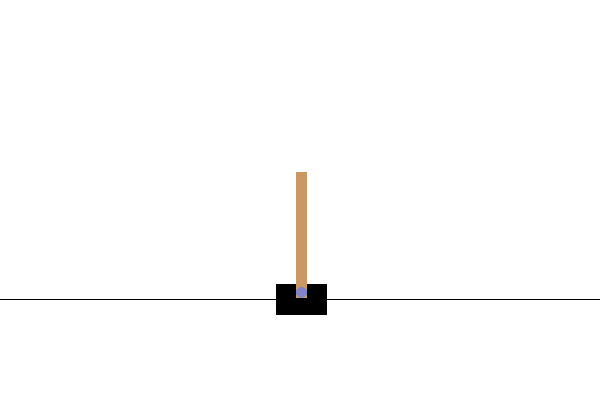

In [14]:
from IPython import display
from PIL import Image
import gymnasium as gym
import numpy as np
import tensorflow as tf
import torch # Import torch

# 1. Create environment with a 3000-step limit (approx 60 seconds at 50fps)
env_long = gym.make('CartPole-v1', render_mode='rgb_array', max_episode_steps=3000)

frames = []
state, _ = env_long.reset()
total_reward = 0

# Get the RLModule instance
# For single-agent environments, the default module ID is 'default_policy'
# You might need to inspect `algo.get_policy_id_map()` if you have multiple policies
rl_module = algo.get_module('default_policy')

# 2. Run for 3000 steps
for t in range(3000):
    # Capture Frame
    frames.append(Image.fromarray(env_long.render()))

    # 3. Deterministic Inference (Best Action)
    state_input = np.expand_dims(state, axis=0).astype(np.float32)

    # Convert numpy array to PyTorch Tensor
    state_input_tensor = torch.from_numpy(state_input)

    # Use the RLModule's forward_inference method
    # The output is a dictionary, and 'action_dist_inputs' is the key for the logits
    action_output = rl_module.forward_inference({'obs': state_input_tensor})

    # Get the action by taking argmax of the action distribution inputs (logits)
    action_logits = action_output['action_dist_inputs']
    action = torch.argmax(action_logits, dim=1).numpy()[0]

    state, reward, terminated, truncated, _ = env_long.step(action)
    total_reward += reward

    # If the pole falls (terminated), we stop early
    if terminated:
        print(f"Agent failed at step {t} (Duration: {t/50:.2f}s)")
        break
    if truncated:
        print("Reached the 1-minute limit!")
        break

env_long.close()

# 4. Save GIF with specific duration
gif_path = 'cartpole_60s.gif'
if frames:
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=20,
        loop=0
    )
    display.display(display.Image(filename=gif_path))